In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset
import torch.nn as nn

import matplotlib.pyplot as plt

# 1. define your dataloader

In [2]:
transform_list = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.131], std=[0.289])])
dataset = datasets.MNIST(root='/tmp/', train=True, download=True, transform=transform_list)
dataset = Subset(dataset, range(2000))

loader = torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=500,
      shuffle=False)

# 2. define your model

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.flatten(1)

n_hidden = 2
hidden_size = 10
device = 'cuda'
layers = [Flatten(), nn.Linear(28 * 28, hidden_size), nn.ReLU()] + \
         [nn.Linear(hidden_size, hidden_size), nn.ReLU()] * (n_hidden - 1) + \
         [nn.Linear(hidden_size, 10), nn.LogSoftmax(dim=1)]
model = nn.Sequential(*layers).to(device)

# 3. define your loss function
For this example here we will compute the MC-sampled Fisher Information Matrix using only 1 sample for each example.

In [4]:
def loss(input, target):
    log_sm = model(input)
    probs = torch.exp(log_sm)
    random_target = torch.multinomial(probs, 1)
    random_log_sm = torch.gather(log_sm, 1, random_target)
    return random_log_sm.sum()

# 4. create your generator

In [5]:
from nngeometry.pspace import L2Loss

l2_generator = L2Loss(model=model, dataloader=loader, loss_closure=loss)

# 5. choose a representation

# 5.1 DenseMatrix representation

In [6]:
from nngeometry.representations import DenseMatrix

F_dense = DenseMatrix(l2_generator)
F = F_dense.get_matrix()

display the end of the FIM (corresponding to the last layer)

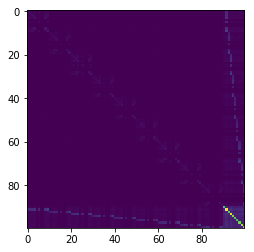

In [7]:
plt.imshow(torch.abs(F)[-100:,-100:].cpu())

display the top 50 eigenvalues (eigenvalues are computed using symeig by default so they are in increasing order)

In [8]:
F_dense.compute_eigendecomposition()
evals, evecs = F_dense.get_eigendecomposition()

Text(0, 0.5, 'eigenvalue')

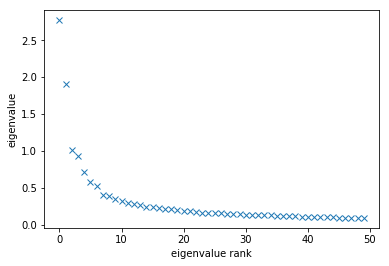

In [9]:
plt.plot(evals[-50:].cpu().numpy()[::-1], marker='x', linestyle="None")
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue')

compute $\sqrt{\mathbf{v}^\top F \mathbf{v}}$ for a random vector $\mathbf{v}$

In [10]:
from nngeometry.vector import Vector

n_parameters = l2_generator.get_n_parameters()
v_flat = torch.rand((n_parameters)).to(device)

v = Vector(model, vector_repr=v_flat)
print(F_dense.m_norm(v))

tensor(9.4840, device='cuda:0')


compute the trace and frobenius norm of $F$

In [11]:
print(F_dense.trace(), F_dense.frobenius_norm())

tensor(25.2303, device='cuda:0') tensor(4.0188, device='cuda:0')


# 5.2 KFACMatrix representation

In [12]:
from nngeometry.representations import KFACMatrix

F_kfac = KFACMatrix(l2_generator)

display the end of the FIM (corresponding to the last layer)

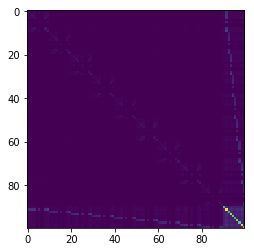

In [13]:
plt.imshow(torch.abs(F_kfac.get_matrix(split_weight_bias=True))[-100:,-100:].cpu())

compute $\sqrt{\mathbf{v}^\top F \mathbf{v}}$ for a random vector $\mathbf{v}$. Note the slight difference with the DenseMatrix above since KFAC is an approximation

In [14]:
print(F_kfac.m_norm(v))

tensor(10.1201, device='cuda:0')


In [15]:
print(F_kfac.trace())

tensor(24.9549, device='cuda:0')
